### Sentiment Analysis of Statements about Finances

Source for the Datasets: 
- https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
- https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

### Exploratory Data Analysis & Preprocessing in Pandas

Importing the Necessary Libraries for the Entire Project

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from datasets import Dataset, DatasetDict

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

Git LFS initialized.


#### Versions of Libraries Used

In [2]:
n = 18

print("Python:".rjust(n), sys.version[0:6])
print("NumPy:".rjust(n), np.__version__)
print("Pandas:".rjust(n), pd.__version__)
print("Datasets:".rjust(n), datasets.__version__)
print("Transformers:".rjust(n), transformers.__version__)
print("Torch:".rjust(n), torch.__version__)
print("Evaluate:".rjust(n), evaluate.__version__)

           Python: 3.9.12
            NumPy: 1.23.5
           Pandas: 2.0.0
         Datasets: 2.11.0
     Transformers: 4.27.4
            Torch: 2.0.0
         Evaluate: 0.4.0


#### Ingest First Dataset & Preprocess it

In [3]:
data1 = pd.read_csv("data.csv", 
                    engine="c",
                    names=["text",
                           "label"],
                    header=0
                    )

data1 = data1.dropna()
data1 = data1.drop_duplicates()

data1['text'] = data1['text'].str.strip()
data1['label'] = data1['label'].str.strip()

data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5836 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5836 non-null   object
 1   label   5836 non-null   object
dtypes: object(2)
memory usage: 136.8+ KB


#### Ingest Second Dataset & Preprocess it

In [4]:
data2 = pd.read_csv("all-data.csv", 
                    encoding_errors='ignore', 
                    engine="c", 
                    names=['label', 
                           'text'],
                    header=0
                    )

data2['label'] = data2['label'].str.strip()
data2['text'] = data2['text'].str.strip()

data2 = data2.drop_duplicates()
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4839 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4839 non-null   object
 1   text    4839 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


#### Combine Both Datasets

In [5]:
data = pd.concat([data1, data2]).reset_index(drop=True)
data.head()

,text,label
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


#### Histogram of Text Lengths

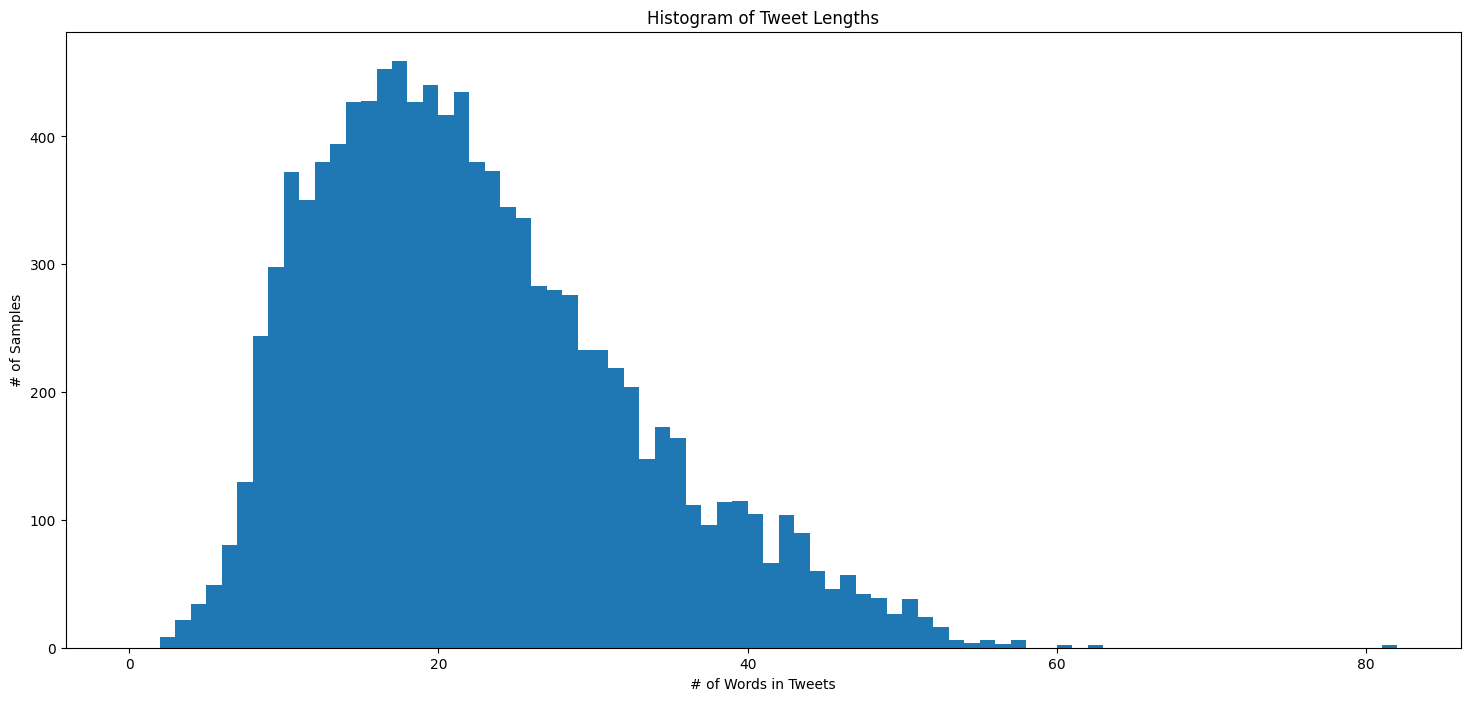

The maximum length of Speeches is 81 words.


In [6]:
data['text_length'] = data['text'].str.split().str.len()

n_bin=82
data.hist('text_length', 
          grid=False, 
          figsize=(18,8), 
          range=(0,n_bin), 
          bins=n_bin)
plt.title('Histogram of Tweet Lengths')
plt.xlabel('# of Words in Tweets')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Speeches is {max(data['text_length'])} words.")

#### Visualize: Description Lengths By Output/Class

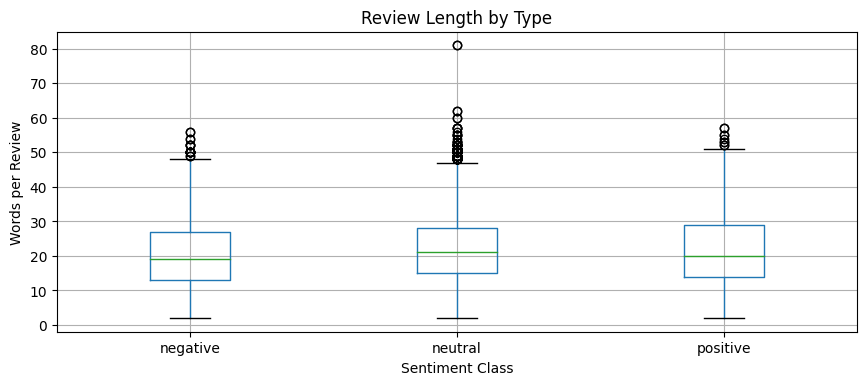

In [7]:
data.boxplot("text_length", 
             by="label", 
             grid=True, 
             showfliers=True,
             figsize=(10,4))

plt.suptitle('')
plt.title('Review Length by Type')
plt.xlabel('Sentiment Class')
plt.ylabel('Words per Review')
plt.show()

#### Class Distribution

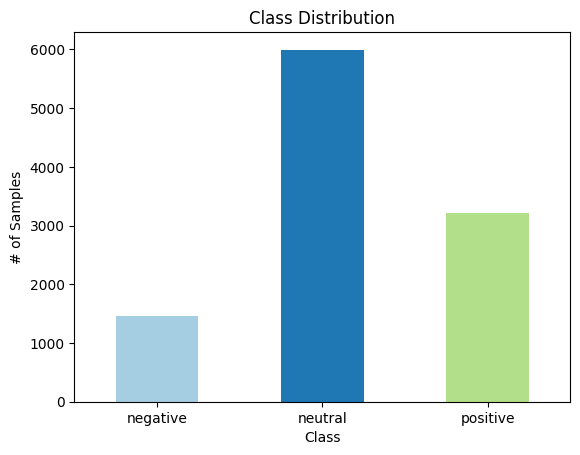

In [8]:
class_counts = data.groupby("label").count()

class_counts['text_length'].plot.bar(label='labels', 
                                     color=plt.cm.Paired(np.arange(len(data))))
plt.suptitle('')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.xticks(rotation = 0)
plt.show()

#### Define Dictionaries to Convert Between String & Integer Class Values

In [9]:
unique_classes = data['label'].unique()

NUM_OF_LABELS = len(unique_classes)

id2label = {idx:label for idx, label in enumerate(unique_classes)}
label2id = {label:idx for idx, label in enumerate(unique_classes)}

#### Remove Overly Lengthy Samples & Unnecessary Features

In [10]:
data = data[data['text_length'] < 61]

data = data.reset_index(drop=True)

data = data.drop(columns=['text_length'])

data['label'] = data['label'].replace(label2id)

data.head()

,text,label
0,The GeoSolutions technology will leverage Bene...,0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1
2,"For the last quarter of 2010 , Componenta 's n...",0
3,According to the Finnish-Russian Chamber of Co...,2
4,The Swedish buyout firm has sold its remaining...,2


#### Convert Pandas Dataframe to Dataset

In [11]:
dataset = Dataset.from_pandas(data)

#### Convert Pandas DataFrame to Dataset & Split into Train/Eval Datasets

In [12]:
# Split into train/eval Subsets
train_eval = dataset.train_test_split(test_size=0.20)

# Combine train/eval into datasetdict
ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test']
})

print(f"Training Dataset Shape: {ds['train'].shape}")
print(f"Evaluation Dataset Shape: {ds['eval'].shape}")
print(f"Training Dataset Features: {ds['train'].features}")

Training Dataset Shape: (8536, 2)
Evaluation Dataset Shape: (2135, 2)
Training Dataset Features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


#### Find Largest Tokenized Input Value

In [13]:
MODEL_CKPT = "google/fnet-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

text_len = [len(tokenizer.encode(a)) for a in data["text"]]

MAX_LENGTH = max(text_len)

print(f"The longest article length is {MAX_LENGTH} tokens.")

The longest article length is 106 tokens.


#### Basic Constants/Values

In [14]:
MODEL_CKPT = "google/fnet-large"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Financial_Sentiment_Analysis_v3"

DEVICE = torch.device("cpu")
MAX_INPUT_LENGTH = MAX_LENGTH + 3

NUM_OF_EPOCHS = 10
BATCH_SIZE = 64

LR = 2e-5
STRATEGY = "epoch"

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

set_seed(42)

print(f"The maximum input length is {MAX_INPUT_LENGTH}.")

The maximum input length is 109.


#### Tokenize Entire Dataset

In [15]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'], 
                     truncation=True, 
                     padding=True, 
                     max_length=MAX_INPUT_LENGTH, 
                     return_tensors="np")

# Map 'Tokenize' Method to Entire Dataset
encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

print('Training Dataset Shape:', encoded_ds['train'].shape)

print('Evaluation Dataset Shape:', encoded_ds['eval'].shape)

Map:   0%|          | 0/8536 [00:00<?, ? examples/s]

Map:   0%|          | 0/2135 [00:00<?, ? examples/s]

Training Dataset Shape: (8536, 4)
Evaluation Dataset Shape: (2135, 4)


#### Check Result of Tokenizing Dataset

In [16]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids'],
    num_rows: 8536
})


#### Instantiate Model

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                           num_labels=NUM_OF_LABELS
                                                           ).to(DEVICE)

model.config.num_labels

Some weights of the model checkpoint at google/fnet-large were not used when initializing FNetForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing FNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FNetForSequenceClassification were not initiali

3

#### Define Function to Compute Metrics

In [18]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions,
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    # Return dictionary that includes all metrics (& their appropriate label)
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Instantiate Data Collator

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### Instantiate TrainingArguments

In [20]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=WEIGHT_DECAY,
    log_level="error",
    logging_strategy="steps", 
    logging_steps=50,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    load_best_model_at_end=True,
    metric_for_best_model="eval_Weighted F1",
    greater_is_better=True,
    logging_first_step=True,
    group_by_length=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True)

#### Subclass Trainer to Correctly Compute Loss Function

In [21]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [22]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/fnet-large-Financial_Sentiment_Analysis_v3 into local empty directory.


#### Train Model

In [23]:
training_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1340 [00:00<?, ?it/s]

{'loss': 1.4558, 'learning_rate': 1.9985074626865674e-05, 'epoch': 0.01}
{'loss': 0.81, 'learning_rate': 1.9253731343283585e-05, 'epoch': 0.37}
{'loss': 0.6757, 'learning_rate': 1.8507462686567165e-05, 'epoch': 0.75}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.5890011787414551, 'eval_accuracy': 0.585480093676815, 'eval_Weighted F1': 0.4739290274173566, 'eval_Micro F1': 0.585480093676815, 'eval_Macro F1': 0.36279759177569026, 'eval_Weighted Recall': 0.585480093676815, 'eval_Micro Recall': 0.585480093676815, 'eval_Macro Recall': 0.4297578136174626, 'eval_Weighted Precision': 0.5912111905595777, 'eval_Micro Precision': 0.585480093676815, 'eval_Macro Precision': 0.5210381627879025, 'eval_runtime': 572.1521, 'eval_samples_per_second': 3.732, 'eval_steps_per_second': 0.059, 'epoch': 1.0}
{'loss': 0.615, 'learning_rate': 1.7761194029850748e-05, 'epoch': 1.12}
{'loss': 0.542, 'learning_rate': 1.701492537313433e-05, 'epoch': 1.49}
{'loss': 0.4815, 'learning_rate': 1.626865671641791e-05, 'epoch': 1.87}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3994453251361847, 'eval_accuracy': 0.7826697892271662, 'eval_Weighted F1': 0.778931131467011, 'eval_Micro F1': 0.7826697892271662, 'eval_Macro F1': 0.7155645405318029, 'eval_Weighted Recall': 0.7826697892271662, 'eval_Micro Recall': 0.7826697892271662, 'eval_Macro Recall': 0.7039245533319153, 'eval_Weighted Precision': 0.7878024754296866, 'eval_Micro Precision': 0.7826697892271662, 'eval_Macro Precision': 0.7388441683808017, 'eval_runtime': 570.0533, 'eval_samples_per_second': 3.745, 'eval_steps_per_second': 0.06, 'epoch': 2.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.3774, 'learning_rate': 1.5522388059701494e-05, 'epoch': 2.24}
{'loss': 0.3366, 'learning_rate': 1.4776119402985077e-05, 'epoch': 2.61}
{'loss': 0.314, 'learning_rate': 1.4029850746268658e-05, 'epoch': 2.99}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3560428321361542, 'eval_accuracy': 0.7990632318501171, 'eval_Weighted F1': 0.7977313198767033, 'eval_Micro F1': 0.7990632318501172, 'eval_Macro F1': 0.736751489500019, 'eval_Weighted Recall': 0.7990632318501171, 'eval_Micro Recall': 0.7990632318501171, 'eval_Macro Recall': 0.7252037377440934, 'eval_Weighted Precision': 0.8100534851227623, 'eval_Micro Precision': 0.7990632318501171, 'eval_Macro Precision': 0.7612057314604446, 'eval_runtime': 581.4066, 'eval_samples_per_second': 3.672, 'eval_steps_per_second': 0.058, 'epoch': 3.0}
{'loss': 0.2486, 'learning_rate': 1.328358208955224e-05, 'epoch': 3.36}
{'loss': 0.235, 'learning_rate': 1.2537313432835823e-05, 'epoch': 3.73}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.32777392864227295, 'eval_accuracy': 0.8201405152224824, 'eval_Weighted F1': 0.8217495227304409, 'eval_Micro F1': 0.8201405152224824, 'eval_Macro F1': 0.7548578890974982, 'eval_Weighted Recall': 0.8201405152224824, 'eval_Micro Recall': 0.8201405152224824, 'eval_Macro Recall': 0.7508943526446905, 'eval_Weighted Precision': 0.8273969119402248, 'eval_Micro Precision': 0.8201405152224824, 'eval_Macro Precision': 0.7630930133664333, 'eval_runtime': 571.7549, 'eval_samples_per_second': 3.734, 'eval_steps_per_second': 0.059, 'epoch': 4.0}
{'loss': 0.2309, 'learning_rate': 1.1791044776119405e-05, 'epoch': 4.1}
{'loss': 0.188, 'learning_rate': 1.1044776119402986e-05, 'epoch': 4.48}
{'loss': 0.1986, 'learning_rate': 1.029850746268657e-05, 'epoch': 4.85}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3573662042617798, 'eval_accuracy': 0.8618266978922716, 'eval_Weighted F1': 0.8655209539834394, 'eval_Micro F1': 0.8618266978922716, 'eval_Macro F1': 0.8208742913000978, 'eval_Weighted Recall': 0.8618266978922716, 'eval_Micro Recall': 0.8618266978922716, 'eval_Macro Recall': 0.8400854990635674, 'eval_Weighted Precision': 0.8723242107411118, 'eval_Micro Precision': 0.8618266978922716, 'eval_Macro Precision': 0.8083647050243598, 'eval_runtime': 572.7753, 'eval_samples_per_second': 3.727, 'eval_steps_per_second': 0.059, 'epoch': 5.0}
{'loss': 0.1838, 'learning_rate': 9.552238805970149e-06, 'epoch': 5.22}
{'loss': 0.1485, 'learning_rate': 8.805970149253732e-06, 'epoch': 5.6}
{'loss': 0.1605, 'learning_rate': 8.059701492537314e-06, 'epoch': 5.97}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3885968029499054, 'eval_accuracy': 0.7995316159250585, 'eval_Weighted F1': 0.7803428354754396, 'eval_Micro F1': 0.7995316159250586, 'eval_Macro F1': 0.6588158445976257, 'eval_Weighted Recall': 0.7995316159250585, 'eval_Micro Recall': 0.7995316159250585, 'eval_Macro Recall': 0.6469038522815648, 'eval_Weighted Precision': 0.778138163263271, 'eval_Micro Precision': 0.7995316159250585, 'eval_Macro Precision': 0.6987220074939374, 'eval_runtime': 571.7311, 'eval_samples_per_second': 3.734, 'eval_steps_per_second': 0.059, 'epoch': 6.0}
{'loss': 0.1425, 'learning_rate': 7.313432835820896e-06, 'epoch': 6.34}
{'loss': 0.1436, 'learning_rate': 6.567164179104478e-06, 'epoch': 6.72}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4039975702762604, 'eval_accuracy': 0.8229508196721311, 'eval_Weighted F1': 0.820676653014847, 'eval_Micro F1': 0.8229508196721311, 'eval_Macro F1': 0.7442069309467508, 'eval_Weighted Recall': 0.8229508196721311, 'eval_Micro Recall': 0.8229508196721311, 'eval_Macro Recall': 0.7336057451045414, 'eval_Weighted Precision': 0.8209948655272054, 'eval_Micro Precision': 0.8229508196721311, 'eval_Macro Precision': 0.7576208137220202, 'eval_runtime': 571.7322, 'eval_samples_per_second': 3.734, 'eval_steps_per_second': 0.059, 'epoch': 7.0}


Several commits (2) will be pushed upstream.


{'loss': 0.1368, 'learning_rate': 5.820895522388061e-06, 'epoch': 7.09}
{'loss': 0.1253, 'learning_rate': 5.074626865671642e-06, 'epoch': 7.46}
{'loss': 0.1373, 'learning_rate': 4.3283582089552236e-06, 'epoch': 7.84}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4517393112182617, 'eval_accuracy': 0.8168618266978923, 'eval_Weighted F1': 0.807557064029797, 'eval_Micro F1': 0.8168618266978923, 'eval_Macro F1': 0.7123175103612404, 'eval_Weighted Recall': 0.8168618266978923, 'eval_Micro Recall': 0.8168618266978923, 'eval_Macro Recall': 0.7019914283796879, 'eval_Weighted Precision': 0.8030050439721781, 'eval_Micro Precision': 0.8168618266978923, 'eval_Macro Precision': 0.7322548905353868, 'eval_runtime': 571.7202, 'eval_samples_per_second': 3.734, 'eval_steps_per_second': 0.059, 'epoch': 8.0}


Several commits (3) will be pushed upstream.


{'loss': 0.1206, 'learning_rate': 3.582089552238806e-06, 'epoch': 8.21}
{'loss': 0.1141, 'learning_rate': 2.835820895522388e-06, 'epoch': 8.58}
{'loss': 0.1271, 'learning_rate': 2.08955223880597e-06, 'epoch': 8.96}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.45325130224227905, 'eval_accuracy': 0.8070257611241218, 'eval_Weighted F1': 0.7944945373911929, 'eval_Micro F1': 0.8070257611241218, 'eval_Macro F1': 0.6891590047543085, 'eval_Weighted Recall': 0.8070257611241218, 'eval_Micro Recall': 0.8070257611241218, 'eval_Macro Recall': 0.6768345177275865, 'eval_Weighted Precision': 0.790593845937712, 'eval_Micro Precision': 0.8070257611241218, 'eval_Macro Precision': 0.7169021915882458, 'eval_runtime': 593.452, 'eval_samples_per_second': 3.598, 'eval_steps_per_second': 0.057, 'epoch': 9.0}
{'loss': 0.1171, 'learning_rate': 1.3432835820895524e-06, 'epoch': 9.33}
{'loss': 0.1199, 'learning_rate': 5.970149253731343e-07, 'epoch': 9.7}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.474141001701355, 'eval_accuracy': 0.824824355971897, 'eval_Weighted F1': 0.8193666524247488, 'eval_Micro F1': 0.824824355971897, 'eval_Macro F1': 0.7368644623841439, 'eval_Weighted Recall': 0.824824355971897, 'eval_Micro Recall': 0.824824355971897, 'eval_Macro Recall': 0.726942967276122, 'eval_Weighted Precision': 0.8163202759848958, 'eval_Micro Precision': 0.824824355971897, 'eval_Macro Precision': 0.7514878901301887, 'eval_runtime': 569.2941, 'eval_samples_per_second': 3.75, 'eval_steps_per_second': 0.06, 'epoch': 10.0}
{'train_runtime': 95644.4856, 'train_samples_per_second': 0.892, 'train_steps_per_second': 0.014, 'train_loss': 0.26616470564657185, 'epoch': 10.0}


#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [24]:
trainer.save_model()
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)
trainer.save_state()

trainer.push_to_hub(commit_message="All Dunn!!!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/904M [00:00<?, ?B/s]

Upload file runs/May08_13-29-44_Brians-Mac-mini.local/events.out.tfevents.1683570591.Brians-Mac-mini.local.147…

To https://huggingface.co/DunnBC22/fnet-large-Financial_Sentiment_Analysis_v3
   fba6a97..8568dc9  main -> main



Upload file .DS_Store: 100%|##########| 10.0k/10.0k [00:00<?, ?B/s]

Upload file runs/.DS_Store: 100%|##########| 6.00k/6.00k [00:00<?, ?B/s]

To https://huggingface.co/DunnBC22/fnet-large-Financial_Sentiment_Analysis_v3
   8568dc9..6106fbe  main -> main



***** train metrics *****
  epoch                    =              10.0
  train_loss               =            0.2662
  train_runtime            = 1 day, 2:34:04.48
  train_samples_per_second =             0.892
  train_steps_per_second   =             0.014


To https://huggingface.co/DunnBC22/fnet-large-Financial_Sentiment_Analysis_v3
   6106fbe..6e37896  main -> main



'https://huggingface.co/DunnBC22/fnet-large-Financial_Sentiment_Analysis_v3/commit/6e378968c8f4b949e2488cd04560995aec1bd891'

#### Evaluate Model

In [25]:
metrics = trainer.evaluate()

print(metrics)

  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3573662042617798, 'eval_accuracy': 0.8618266978922716, 'eval_Weighted F1': 0.8655209539834394, 'eval_Micro F1': 0.8618266978922716, 'eval_Macro F1': 0.8208742913000978, 'eval_Weighted Recall': 0.8618266978922716, 'eval_Micro Recall': 0.8618266978922716, 'eval_Macro Recall': 0.8400854990635674, 'eval_Weighted Precision': 0.8723242107411118, 'eval_Micro Precision': 0.8618266978922716, 'eval_Macro Precision': 0.8083647050243598, 'eval_runtime': 572.4513, 'eval_samples_per_second': 3.73, 'eval_steps_per_second': 0.059, 'epoch': 10.0}


### Notes & Other Takeaways From This Project
****
- Even though the results are better than the results were for the base checkpoint, I am frustrated that results did not yield even better results.

****

### Citation(s)

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2105-03824, author = {James Lee{-}Thorp and Joshua Ainslie and Ilya Eckstein and Santiago Onta{\~{n}}{\'{o}}n}, title = {FNet: Mixing Tokens with Fourier Transforms}, journal   = {CoRR}, volume = {abs/2105.03824}, year = {2021}, url = {https://arxiv.org/abs/2105.03824}, archivePrefix = {arXiv}, eprint = {2105.03824}, timestamp = {Fri, 14 May 2021 12:13:30 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2105-03824.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}
